In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd
from imblearn.over_sampling import SMOTE  


In [2]:
import models
import class_sampling
import train
import metric_utils
import inference
import loss_fns
import torchvision.ops 

In [3]:
NUM_CLASSES = 10
n_epochs = 30
batch_size_train = 64
batch_size_test = 1000
momentum = 0

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

NUM_CLASSES_REDUCED = 2
nums = (0, 1)
ratio = (100, 1)

CLASS_LABELS = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}


simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
col_names = ["name", 
            "num_classes", 
            "classes_used", 
            "ratio", 
            "learning_rate", 
            "mean_0", "variance_0",
            "mean_10", "variance_10",
            "mean_20", "variance_20",
            "mean_30", "variance_30",
             "mean_40", "variance_40",
             "mean_50", "variance_50",
             "cap"]

rows = []

In [5]:
train_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor() ]))  


test_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

train_CIFAR10.data = train_CIFAR10.data.reshape(50000, 3, 32, 32)
test_CIFAR10.data = test_CIFAR10.data.reshape(10000, 3, 32, 32)

    
reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)

triplet_train_CIFAR10 = class_sampling.ForTripletLoss(reduced_train_CIFAR10, smote=False)

smote_train_CIFAR10 = class_sampling.Smote(ratio_train_CIFAR10, 5000 * NUM_CLASSES_REDUCED)
triplet_train_CIFAR10_smote = class_sampling.ForTripletLoss(smote_train_CIFAR10, smote=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
targets = ratio_train_CIFAR10.labels 

class_count = np.unique(targets, return_counts=True)[1]
print(class_count)

weight = 1. / class_count

samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= class_count[0]

[5000   50]


In [7]:
beta = 0.999 

exp = np.empty_like(targets)
for i, count in enumerate(class_count):
    exp[targets==i] = count
effective_weights = (1 - beta) / ( 1 - (beta ** torch.from_numpy(exp)))

In [8]:
train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

train_loader_tripletloss = DataLoader(triplet_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

train_loader_tripletloss_smote = DataLoader(triplet_train_CIFAR10_smote, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [ ]:
# 2 CLASS normal

momentum=0
learning_rates = [1e-4, 1e-5]

learning_rate_aucs = []


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["normal", 2, nums, (1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])


df2.to_csv('results/convnet_aucs.csv', index=False)

rows = []


In [ ]:
# 2 CLASS ratio

momentum=0
learning_rates = [1e-3]

learning_rate_aucs = []
learning_rate_train_aucs = []


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                _, train_auc = metric_utils.auc_sigmoid(train_loader_ratio, network) 
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


In [21]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [31]:
# 2 CLASS oversampled

momentum=0
learning_rates = [1e-3]

learning_rate_aucs = []


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)




Test set: Avg. loss: 0.0009614106118679046, AUC: 0.614011


Test set: Avg. loss: 0.0006774698793888092, AUC: 0.6585589999999999


Test set: Avg. loss: 0.0006662350296974182, AUC: 0.713206


Test set: Avg. loss: 0.0006555393636226654, AUC: 0.7449055


Test set: Avg. loss: 0.006931622505187988, AUC: 0.532071


Test set: Avg. loss: 0.0006511834263801575, AUC: 0.705865


Test set: Avg. loss: 0.0006510878801345825, AUC: 0.7048525


Test set: Avg. loss: 0.0006323479413986206, AUC: 0.74831


Test set: Avg. loss: 0.0012074116468429566, AUC: 0.45304300000000003


Test set: Avg. loss: 0.0006792399287223815, AUC: 0.6182110000000001


Test set: Avg. loss: 0.0006664896011352539, AUC: 0.667305


Test set: Avg. loss: 0.0006620110869407654, AUC: 0.6808749999999999


Test set: Avg. loss: 0.005842076301574707, AUC: 0.35606649999999995


Test set: Avg. loss: 0.0006702626347541809, AUC: 0.6863610000000001


Test set: Avg. loss: 0.0006543796062469482, AUC: 0.7483445000000001


Test set: Avg. loss: 0.00063

In [32]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [33]:
# 2 CLASS undersampled

momentum=0
learning_rates = [1e-4, 1e-5]

learning_rate_aucs = []


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.002664048075675964, AUC: 0.35103100000000004


Test set: Avg. loss: 0.0008118733763694763, AUC: 0.39093300000000003


Test set: Avg. loss: 0.0007359330058097839, AUC: 0.42988400000000004


Test set: Avg. loss: 0.0007080410122871399, AUC: 0.476849


Test set: Avg. loss: 0.005757878303527832, AUC: 0.4101775


Test set: Avg. loss: 0.0008514148592948913, AUC: 0.663575


Test set: Avg. loss: 0.0006793743073940277, AUC: 0.6388240000000001


Test set: Avg. loss: 0.0006851064562797546, AUC: 0.599984


Test set: Avg. loss: 0.001174522042274475, AUC: 0.498127


Test set: Avg. loss: 0.0009026037454605102, AUC: 0.569188


Test set: Avg. loss: 0.0007478025853633881, AUC: 0.5202549999999999


Test set: Avg. loss: 0.0007039127349853516, AUC: 0.5297069999999999


Test set: Avg. loss: 0.0009038377702236175, AUC: 0.47197


Test set: Avg. loss: 0.0007971824407577515, AUC: 0.48862799999999995


Test set: Avg. loss: 0.0007626304626464844, AUC: 0.494027


Test set: Avg. loss: 0.00074

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [ ]:
# 2 Class Weighted Loss 

momentum=0
learning_rates = [1e-3]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['pos_weight'] = torch.tensor([weight[1]])


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                _, train_auc = metric_utils.auc_sigmoid(train_loader_ratio, network) 
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


In [34]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [9]:
# 2 CLASS SMOTE

momentum=0
learning_rates = [1e-4, 1e-5]

learning_rate_aucs = []


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_smote, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.001968830943107605, AUC: 0.6361665000000001



KeyboardInterrupt: 

In [36]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [12]:
# 2 Class Capped SMOTE 

momentum=0
learning_rates = [1e-3, 1e-4]


cap_aucs = []

caps = [1, 5, 10]

for cap in caps:
    
    loss_fn_args = {}
    loss_fn_args['loss_cap'] = cap
    
    learning_rate_aucs = []
    

    for learning_rate in learning_rates:
        aucs = []
        for i in range(10):
            model_aucs = []
            network = models.ConvNet(NUM_CLASSES_REDUCED)
            optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
            model_aucs.append(auc)
            for epoch in range(n_epochs):
                _, _ = train.train_sigmoid(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss, loss_fn_args=loss_fn_args, smote=True)
                if (epoch + 1) % 10 == 0: 
                    _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                    model_aucs.append(auc)
            aucs.append(model_aucs)
        learning_rate_aucs.append(aucs)

    learning_rate_aucs = np.asarray(learning_rate_aucs)

    auc_mean = np.mean(learning_rate_aucs, axis=1)
    auc_variance = np.var(learning_rate_aucs, axis=1)
    
    
    cap_aucs.append([auc_mean, auc_variance])

    
    
for i in range(len(cap_aucs)):
    auc_mean = cap_aucs[i][0]
    auc_variance = cap_aucs[i][1]
    cap = caps[i]
    for i in range(len(learning_rates)): 
        row = ["capped_smote", 2, nums, ratio, learning_rates[i],
                auc_mean[i][0], auc_variance[i][0], 
                auc_mean[i][1], auc_variance[i][1],
                auc_mean[i][2], auc_variance[i][2],
                auc_mean[i][3], auc_variance[i][3], cap]
        rows.append(row)

print(rows)



Test set: Avg. loss: 0.001968830943107605, AUC: 0.6361665000000001


Test set: Avg. loss: 0.0005031153112649918, AUC: 0.8974789999999999


Test set: Avg. loss: 0.0005469995141029358, AUC: 0.9000029999999999


Test set: Avg. loss: 0.00084603151679039, AUC: 0.88369


Test set: Avg. loss: 0.0032240989208221437, AUC: 0.38664699999999996


Test set: Avg. loss: 0.0005088528543710708, AUC: 0.8884839999999999


Test set: Avg. loss: 0.0005007016658782959, AUC: 0.8948050000000001


Test set: Avg. loss: 0.0016704701781272888, AUC: 0.8813089999999999


Test set: Avg. loss: 0.006873347997665405, AUC: 0.683021


Test set: Avg. loss: 0.0014531199336051941, AUC: 0.7342400000000001


Test set: Avg. loss: 0.000498114362359047, AUC: 0.8572739999999999


Test set: Avg. loss: 0.0011343847513198852, AUC: 0.8791939999999999


Test set: Avg. loss: 0.001451125681400299, AUC: 0.47390000000000004


Test set: Avg. loss: 0.0007161926329135895, AUC: 0.8914880000000002


Test set: Avg. loss: 0.0008789804279804229, 


Test set: Avg. loss: 0.0006228884160518647, AUC: 0.8189550000000001


Test set: Avg. loss: 0.0035049201250076296, AUC: 0.364836


Test set: Avg. loss: 0.0006428403854370117, AUC: 0.7701835


Test set: Avg. loss: 0.0006446835100650788, AUC: 0.77815


Test set: Avg. loss: 0.0006226344704627991, AUC: 0.8041910000000001


Test set: Avg. loss: 0.00241806423664093, AUC: 0.3173455


Test set: Avg. loss: 0.0006310730576515197, AUC: 0.8121910000000001


Test set: Avg. loss: 0.0006201047599315643, AUC: 0.829522


Test set: Avg. loss: 0.0006243416666984558, AUC: 0.8286870000000001


Test set: Avg. loss: 0.001278232514858246, AUC: 0.507354


Test set: Avg. loss: 0.0006941431760787964, AUC: 0.49647


Test set: Avg. loss: 0.0006938660740852356, AUC: 0.498515


Test set: Avg. loss: 0.0006937801837921143, AUC: 0.500014


Test set: Avg. loss: 0.0020855687856674195, AUC: 0.4122905


Test set: Avg. loss: 0.0006648121476173401, AUC: 0.7229209999999999


Test set: Avg. loss: 0.0006386235058307648, AUC: 0.

In [13]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = (col_names))

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [37]:
# 2 CLASS Focal Loss

momentum=0
learning_rates = [1e-4, 1e-5]

learning_rate_aucs = []

loss_fn_args = {}


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SigmoidFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.001035837471485138, AUC: 0.44774200000000003


Test set: Avg. loss: 0.0006927213966846466, AUC: 0.5254145


Test set: Avg. loss: 0.0006931669712066651, AUC: 0.511691


Test set: Avg. loss: 0.0006935113668441773, AUC: 0.5110125


Test set: Avg. loss: 0.005613439321517945, AUC: 0.426767


Test set: Avg. loss: 0.0037078361511230467, AUC: 0.5171749999999999


Test set: Avg. loss: 0.0026477036476135253, AUC: 0.46210599999999996


Test set: Avg. loss: 0.002063918948173523, AUC: 0.44280450000000005


Test set: Avg. loss: 0.001599363923072815, AUC: 0.5595060000000001


Test set: Avg. loss: 0.0017810710668563843, AUC: 0.527251


Test set: Avg. loss: 0.0017536671757698058, AUC: 0.530268


Test set: Avg. loss: 0.001468895673751831, AUC: 0.511718


Test set: Avg. loss: 0.0009869316220283508, AUC: 0.521323


Test set: Avg. loss: 0.0025733143091201784, AUC: 0.44177999999999995


Test set: Avg. loss: 0.002441696286201477, AUC: 0.42422899999999997


Test set: Avg. loss: 0.00228

In [38]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

NameError: name 'df2' is not defined

In [22]:
# distance + capped loss
momentum=0
learning_rates = [1e-2, 1e-5]


    
loss_fn_args = {}
loss_fn_args['loss_cap'] = None

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNetWithEmbeddings(2)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid_euclidean_distance(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)


for i in range(len(learning_rates)): 
    row = ["distance_capped_smote_fixed", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


Test set: Avg. loss: 0.001713291108608246, AUC: 0.572522


Test set: Avg. loss: 0.0007095660865306854, AUC: 0.4930185


Test set: Avg. loss: 0.0007561078071594238, AUC: 0.48606199999999994


Test set: Avg. loss: 0.0007982843816280365, AUC: 0.48059299999999994


Test set: Avg. loss: 0.006548434972763062, AUC: 0.3809975


Test set: Avg. loss: 0.0006931488215923309, AUC: 0.5


Test set: Avg. loss: 0.000693147212266922, AUC: 0.5


Test set: Avg. loss: 0.0006931480169296264, AUC: 0.5


Test set: Avg. loss: 0.0012743324041366577, AUC: 0.531981


Test set: Avg. loss: 0.0007263560891151428, AUC: 0.783012


Test set: Avg. loss: 0.0007811572551727295, AUC: 0.635699


Test set: Avg. loss: 0.0009450841844081878, AUC: 0.8064009999999999


Test set: Avg. loss: 0.0008527356088161469, AUC: 0.638988


Test set: Avg. loss: 0.0006933750212192535, AUC: 0.501984


Test set: Avg. loss: 0.0007121953666210175, AUC: 0.4820955


Test set: Avg. loss: 0.0007565244734287262, AUC: 0.4625580000000001


Test set: Av

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [9]:
# cosine distance + capped loss
momentum=0
learning_rates = [1e-3]


    
loss_fn_args = {}
loss_fn_args['loss_cap'] = None

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNetWithEmbeddings(2)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid_cosine_distance(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)


for i in range(len(learning_rates)): 
    row = ["cosine_distance_capped_smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


Test set: Avg. loss: 0.0011436396837234497, AUC: 0.457495

tensor([0.4864,    nan, 0.1976,    nan,    nan,    nan,    nan,    nan, 0.4864,
           nan, 0.1988,    nan,    nan, 0.2524, 0.4446,    nan, 0.3864,    nan,
        0.4864, 0.5528,    nan, 0.2667,    nan,    nan, 0.3599, 0.3651,    nan,
           nan, 0.3887, 0.2463, 0.2289,    nan,    nan, 0.2215, 0.4790, 0.4394,
           nan,    nan, 0.4864,    nan, 0.4785, 0.3570, 0.3376, 0.4941,    nan,
           nan,    nan,    nan,    nan, 0.4090,    nan, 0.4213,    nan,    nan,
        0.4937,    nan,    nan, 0.2548,    nan, 0.4571,    nan,    nan,    nan,
           nan], grad_fn=<IndexPutBackward0>)
torch.Size([64])
tensor([   nan,    nan, 0.4166,    nan,    nan, 0.5076, 0.4801,    nan, 0.4190,
           nan,    nan, 0.4801, 0.5311, 0.4935,    nan, 0.1738,    nan,    nan,
           nan,    nan, 0.4801, 0.4145, 0.3991, 0.4315, 0.4502, 0.4801, 0.4294,
           nan,    nan,    nan,    nan,    nan, 0.4248, 0.4907, 0.4878,    na

tensor([   nan,    nan, 0.3879, 0.3879, 0.3879, 0.3879, 0.4858,    nan, 0.3879,
        0.3879,    nan,    nan, 0.3879,    nan,    nan,    nan,    nan,    nan,
        0.3879, 0.3879,    nan, 0.5690, 0.3879, 0.5740, 0.3879,    nan, 0.3879,
           nan, 0.3879,    nan,    nan, 0.3879, 0.3879,    nan, 0.3879,    nan,
        0.2402, 0.4807, 0.4291,    nan,    nan, 0.3879,    nan,    nan,    nan,
           nan,    nan, 0.4001, 0.3879,    nan,    nan, 0.1119, 0.4402,    nan,
        0.3879,    nan,    nan,    nan, 0.3884, 0.3879, 0.3879, 0.3879, 0.3879,
           nan], grad_fn=<IndexPutBackward0>)
torch.Size([64])
tensor([0.2963, 0.2963,    nan,    nan, 0.3298,    nan,    nan,    nan, 0.3733,
           nan,    nan, 0.2963, 0.4484,    nan, 0.2963,    nan,    nan,    nan,
           nan, 0.2963, 0.2963, 0.3189, 0.2963,    nan,    nan,    nan, 0.2963,
        0.3949, 0.3367, 0.2963, 0.2963,    nan,    nan, 0.2963,    nan,    nan,
           nan, 0.2963,    nan, 0.3061, 0.4120,    nan, 0

tensor([0.3783, 0.5092,    nan, 0.1992,    nan,    nan, 0.3783, 0.4814,    nan,
           nan, 0.4782, 0.3783, 0.3783, 0.3783,    nan, 0.3783,    nan,    nan,
        0.3783, 0.3783,    nan,    nan,    nan, 0.3851,    nan,    nan,    nan,
        0.3783, 0.4622,    nan,    nan,    nan,    nan, 0.3783, 0.3783, 0.3783,
        0.4649, 0.4586,    nan, 0.3766, 0.3783,    nan, 0.3783,    nan, 0.3783,
        0.3783, 0.5000,    nan, 0.3783,    nan,    nan,    nan, 0.2149,    nan,
           nan, 0.3783,    nan, 0.3751, 0.3903, 0.3783, 0.3783,    nan,    nan,
           nan], grad_fn=<IndexPutBackward0>)
torch.Size([64])
tensor([   nan,    nan, 0.3779, 0.4250, 0.4040,    nan, 0.2728,    nan,    nan,
           nan, 0.2710, 0.2567,    nan, 0.4250,    nan,    nan, 0.4077,    nan,
        0.4250,    nan,    nan,    nan,    nan, 0.4250,    nan, 0.4250, 0.2469,
           nan, 0.4250, 0.4250, 0.4250, 0.4250, 0.4250, 0.1823, 0.4250,    nan,
           nan,    nan,    nan, 0.4133,    nan,    nan,  

tensor([   nan,    nan, 0.4310, 0.4402, 0.4310,    nan,    nan, 0.3876,    nan,
           nan,    nan, 0.4310,    nan,    nan, 0.4370, 0.4310,    nan,    nan,
        0.4039,    nan, 0.4310, 0.3618,    nan,    nan, 0.4310, 0.4071, 0.2616,
        0.4310, 0.3815, 0.4310,    nan, 0.4310,    nan,    nan, 0.4310, 0.4731,
        0.4310,    nan,    nan, 0.3114,    nan, 0.4310,    nan, 0.4310, 0.2465,
        0.4310,    nan,    nan, 0.4310, 0.2163,    nan, 0.4981,    nan,    nan,
        0.3042, 0.4310, 0.5031, 0.4310,    nan, 0.4310,    nan, 0.4310, 0.4310,
           nan], grad_fn=<IndexPutBackward0>)
torch.Size([64])
tensor([0.3880,    nan,    nan,    nan, 0.3880,    nan, 0.3880, 0.3880,    nan,
        0.3880,    nan, 0.2839,    nan, 0.3880,    nan,    nan, 0.3880,    nan,
           nan,    nan, 0.3880,    nan,    nan, 0.3880, 0.2737,    nan, 0.3880,
        0.3880,    nan,    nan, 0.3880, 0.3880,    nan, 0.3880, 0.2252,    nan,
        0.3880, 0.3880,    nan,    nan,    nan, 0.3880, 0

tensor([0.3690,    nan, 0.3990,    nan, 0.3690, 0.3690, 0.3690,    nan,    nan,
           nan, 0.3690,    nan,    nan, 0.3690,    nan,    nan, 0.3690,    nan,
           nan,    nan,    nan, 0.3690, 0.3690,    nan, 0.4416,    nan, 0.4821,
        0.4062,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
        0.3690, 0.3690,    nan, 0.0926, 0.3690, 0.3690,    nan, 0.3690, 0.3690,
        0.3690,    nan, 0.3690,    nan, 0.3690,    nan, 0.4170, 0.3690,    nan,
        0.3690, 0.4927, 0.3690, 0.3690,    nan,    nan,    nan,    nan,    nan,
        0.3690], grad_fn=<IndexPutBackward0>)
torch.Size([64])
tensor([   nan, 0.3393,    nan, 0.3393, 0.3393,    nan, 0.5145, 0.3393, 0.3393,
        0.3393, 0.5539, 0.3393,    nan, 0.3393, 0.3393,    nan, 0.4359, 0.3393,
           nan,    nan,    nan,    nan, 0.3393, 0.3393,    nan,    nan, 0.3393,
           nan, 0.3393, 0.3393, 0.3393, 0.3393,    nan, 0.0900, 0.3393,    nan,
           nan, 0.3393, 0.3393, 0.3393,    nan, 0.3393, 0

tensor([   nan, 0.5901, 0.4754,    nan,    nan, 0.4865,    nan,    nan,    nan,
           nan, 0.1128, 0.4865, 0.4865,    nan,    nan,    nan,    nan,    nan,
        0.4865, 0.4865, 0.4865,    nan,    nan, 0.4865, 0.2347,    nan,    nan,
        0.5617, 0.4241,    nan,    nan,    nan, 0.4865, 0.4865,    nan,    nan,
           nan,    nan, 0.2229, 0.4159, 0.4761, 0.4739, 0.5241,    nan,    nan,
           nan,    nan, 0.3394, 0.4865,    nan,    nan, 0.4865,    nan,    nan,
        0.4865, 0.4865, 0.4633,    nan,    nan,    nan,    nan, 0.4865,    nan,
           nan], grad_fn=<IndexPutBackward0>)
torch.Size([64])
tensor([   nan, 0.3493, 0.2389, 0.3091,    nan,    nan, 0.4427,    nan, 0.3624,
           nan, 0.4288, 0.3624,    nan, 0.3624, 0.3624, 0.4683,    nan, 0.3701,
           nan,    nan,    nan,    nan, 0.3624,    nan,    nan,    nan,    nan,
           nan, 0.3624, 0.3624,    nan, 0.3178,    nan,    nan, 0.3624,    nan,
           nan, 0.3624, 0.3624,    nan, 0.3624,    nan,  

tensor([0.4006,    nan, 0.4875, 0.4875, 0.4875, 0.4993, 0.1554, 0.4875, 0.3572,
        0.2687, 0.3009, 0.4875,    nan,    nan,    nan, 0.4875,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan, 0.5087,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan, 0.4175,
        0.4876,    nan, 0.2745, 0.4875, 0.4875, 0.4875, 0.3103, 0.4875, 0.3839,
        0.4688, 0.5285, 0.4875, 0.4875,    nan, 0.4875,    nan, 0.5272, 0.4458,
        0.4875, 0.1703,    nan, 0.3450,    nan,    nan,    nan,    nan, 0.4875,
           nan], grad_fn=<IndexPutBackward0>)
torch.Size([64])
tensor([5.8543e-01, 5.9605e-08, 5.7589e-01, 4.0490e-01, 4.4411e-01, 4.0490e-01,
        4.0490e-01, 6.1267e-01, 4.0490e-01, 6.5238e-01, 7.1318e-01, 6.5238e-01,
        6.6289e-01, 4.0490e-01, 4.0490e-01, 5.1341e-01, 4.0490e-01, 7.5683e-01,
        4.0490e-01, 4.0490e-01, 4.1598e-01, 5.2583e-01, 6.6266e-01, 4.8279e-01,
        4.0490e-01, 4.6524e-01, 6.2224e-01, 4.0490e-01, 4

tensor([   nan,    nan,    nan, 0.4180, 0.0741,    nan,    nan, 0.4180,    nan,
        0.4280, 0.4387,    nan, 0.4180,    nan,    nan,    nan],
       grad_fn=<IndexPutBackward0>)
torch.Size([16])
tensor([   nan,    nan, 0.4051, 0.4051,    nan,    nan, 0.4051,    nan, 0.4051,
        0.2368,    nan, 0.4051,    nan,    nan, 0.4051, 0.4051,    nan, 0.4051,
        0.4051, 0.4051, 0.4869,    nan,    nan, 0.4051, 0.4795,    nan, 0.4024,
           nan, 0.4051,    nan, 0.4051,    nan,    nan, 0.4051,    nan,    nan,
        0.3939,    nan,    nan,    nan,    nan, 0.3132,    nan,    nan, 0.2605,
           nan, 0.4051,    nan,    nan,    nan,    nan, 0.2857, 0.4051,    nan,
           nan, 0.4051,    nan, 0.3786,    nan, 0.4051,    nan, 0.4401,    nan,
        0.4338], grad_fn=<IndexPutBackward0>)
torch.Size([64])
tensor([0.4580,    nan, 0.4580,    nan, 0.4580,    nan,    nan, 0.4580,    nan,
        0.4580,    nan,    nan,    nan,    nan,    nan, 0.4580, 0.4580, 0.3546,
        0.4580, 0.5

tensor([0.5150, 0.5850, 0.3156, 0.3743, 0.3743, 0.3743, 0.5870, 0.5219, 0.3743,
        0.4024, 0.6017, 0.3743, 0.6106, 0.3743, 0.3108, 0.6613, 0.3743, 0.3743,
        0.3743, 0.6509, 0.6495, 0.2674, 0.3743, 0.6991, 0.3743, 0.0000, 0.7568,
        0.3743, 0.0000, 0.0000, 0.3743, 0.3743, 0.3743, 0.4491, 0.0000, 0.3010,
        0.4227, 0.6540, 0.7245, 0.6766, 0.3743, 0.3743, 0.3743, 0.6893, 0.3743,
        0.6544, 0.3743, 0.7416, 0.3743, 0.3743, 0.3743, 0.2982, 0.6911, 0.2120,
        0.4183, 0.7004, 0.7475, 0.3743, 0.4348, 0.3743, 0.6540, 0.3743, 0.4320,
        0.3743], grad_fn=<IndexPutBackward0>)
torch.Size([64])
tensor([0.5026,    nan, 0.3463,    nan, 0.4446,    nan,    nan, 0.4446,    nan,
        0.4446,    nan, 0.3691, 0.4506, 0.4446,    nan,    nan,    nan,    nan,
        0.3596,    nan, 0.4446,    nan,    nan,    nan, 0.3522,    nan, 0.4446,
           nan,    nan, 0.4446,    nan, 0.4446,    nan, 0.4446, 0.4446,    nan,
           nan,    nan,    nan, 0.4446,    nan,    nan, 0

tensor([5.6718e-01, 2.2144e-01, 2.2144e-01, 2.2144e-01, 6.1052e-01, 1.1921e-07,
        5.9510e-01, 2.2144e-01, 2.2144e-01, 5.0440e-01, 1.1921e-07, 1.1921e-07,
        2.2144e-01, 7.6830e-01, 2.2144e-01, 2.2144e-01, 5.9515e-01, 2.2144e-01,
        6.1090e-01, 7.0220e-01, 1.1921e-07, 6.5845e-01, 6.6969e-01, 4.8911e-01,
        2.2144e-01, 8.5406e-01, 1.1921e-07, 5.4238e-01, 2.2144e-01, 2.2144e-01,
        2.2144e-01, 2.2144e-01, 6.8808e-01, 3.2776e-01, 3.5123e-01, 7.3964e-01,
        5.1015e-01, 2.2144e-01, 6.2232e-01, 5.3941e-01, 2.2144e-01, 2.6323e-01,
        6.1226e-01, 5.0115e-01, 2.2144e-01, 6.5448e-01, 3.8824e-01, 3.3576e-01,
        2.2144e-01, 2.2144e-01, 2.2144e-01, 2.2144e-01, 2.2144e-01, 5.8526e-01,
        5.0738e-01, 1.1921e-07, 3.2396e-01, 2.2144e-01, 6.4676e-01, 2.3200e-01,
        5.8964e-01, 2.2144e-01, 6.4224e-01, 2.2144e-01],
       grad_fn=<IndexPutBackward0>)
torch.Size([64])
tensor([0.3361, 0.3361, 0.3993,    nan,    nan,    nan, 0.3361, 0.3361, 0.3361,
          

KeyboardInterrupt: 

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [9]:
# capped loss with everything capped + cosine distance 
momentum=0
learning_rates = [1e-3, 1e-4, 1e-5]

    
loss_fn_args = {}
loss_fn_args['loss_cap'] = None

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNetWithEmbeddings(2)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid_cosine_distance(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.AllCappedBCELoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)


for i in range(len(learning_rates)): 
    row = ["cosine_distance_all_capped", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


Test set: Avg. loss: 0.0011436396837234497, AUC: 0.457495


Test set: Avg. loss: 0.0006499694585800171, AUC: 0.77029


Test set: Avg. loss: 0.0005454809069633484, AUC: 0.882447


Test set: Avg. loss: 0.0006668661534786224, AUC: 0.7796329999999999


Test set: Avg. loss: 0.00553279709815979, AUC: 0.2802325


Test set: Avg. loss: 0.0006955685317516327, AUC: 0.49733599999999994


Test set: Avg. loss: 0.0006947574317455291, AUC: 0.5028275000000001


Test set: Avg. loss: 0.0007007570564746857, AUC: 0.47190100000000007


Test set: Avg. loss: 0.0016392868161201478, AUC: 0.362875


Test set: Avg. loss: 0.0006936477720737457, AUC: 0.49204799999999993


Test set: Avg. loss: 0.0006933434009552002, AUC: 0.49849199999999994


Test set: Avg. loss: 0.0006933499574661255, AUC: 0.49849200000000005


Test set: Avg. loss: 0.0008223848342895508, AUC: 0.448507


Test set: Avg. loss: 0.0005438280999660492, AUC: 0.8846880000000001


Test set: Avg. loss: 0.0005088721215724945, AUC: 0.8861960000000001


Test s

In [10]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

ValueError: 18 columns passed, passed data had 13 columns

In [ ]:
# 2 class triplet loss no ratio 
# no smote 

# combine network - don't need to turn off grad for embeds 
# double check this 


momentum=0
learning_rates = [(1e-7, 1e-4)]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(2): 
        model_aucs = []
        embed_network = models.ConvNetOnlyEmbeddings(2)
        linear_probe = models.ConvNetLinearProbe(2)
        complete_network = models.CompleteConvNet(embed_network, linear_probe)
        embed_optimizer = optim.SGD(embed_network.parameters(), lr=learning_rate[0], momentum=momentum)
        linear_optimizer = optim.SGD(complete_network.parameters(), lr=learning_rate[1], momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, train_losses = train.train_triplet_loss(epoch, train_loader_tripletloss, embed_network, embed_optimizer, verbose=False)
            print("Train loss: " + str(np.mean(np.array(train_losses))))
        for epoch in range(50):
            _, _ = train.train_linear_probe(epoch, train_loader_reduced, complete_network, linear_optimizer, verbose=False)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network)
            if (epoch + 1) % 10 == 0: 
                model_aucs.append(auc) 
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)
learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["triplet_loss", 2, nums, (1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3], 
           auc_mean[i][4], auc_variance[i][4],
           auc_mean[i][5], auc_variance[i][5],
           None]
    rows.append(row)


Test set: Avg. loss: 0.0007788240313529968, AUC: 0.611374

Train loss: 119.01280592049763
Train loss: 28.864070757179505
Train loss: 17.1626423350565
Train loss: 11.034691510306802
Train loss: 8.068073830407137
Train loss: 7.819459002488737
Train loss: 7.143890395665625
Train loss: 4.397538065530692
Train loss: 4.995529130765587
Train loss: 4.556520942669765
Train loss: 3.594089006162753
Train loss: 3.3297106057974943
Train loss: 3.086767008729801
Train loss: 2.271824208034831
Train loss: 2.06402232958253
Train loss: 2.0588491676719327
Train loss: 2.3586609469857187
Train loss: 2.0566104920047104
Train loss: 1.7273476567997295
Train loss: 1.7904064803366448
Train loss: 1.5368473404532026
Train loss: 1.8114646699777834
Train loss: 1.1535253866462951
Train loss: 1.1687455194391263
Train loss: 1.0392256022258928
Train loss: 1.0467016427380265
Train loss: 1.097411612701264
Train loss: 1.0484806627604613
Train loss: 0.860904399946237
Train loss: 0.9343751817941666

Test set: Avg. loss: 0.0

([], [])

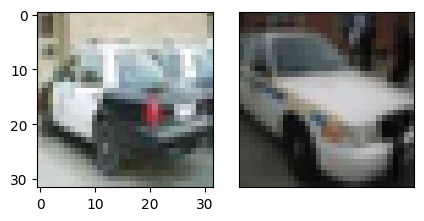

In [67]:
plt.subplot(2,3,1)
plt.tight_layout()
plt.imshow(example[0].reshape(32, 32, 3).int())
plt.subplot(2,3,2)
plt.imshow(example[5].reshape(32, 32, 3).int())
plt.xticks([])
plt.yticks([])

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [ ]:
# triplet loss with ratio 
# need to make a new train loader if running this 

momentum=0
learning_rates = [(1e-7, 1e-3)]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(2):
        model_aucs = []
        embed_network = models.ConvNetOnlyEmbeddings(2)
        linear_probe = models.ConvNetLinearProbe(2)
        complete_network = models.CompleteConvNet(embed_network, linear_probe)
        embed_optimizer = optim.SGD(embed_network.parameters(), lr=learning_rate[0], momentum=momentum)
        linear_optimizer = optim.SGD(linear_probe.parameters(), lr=learning_rate[1], momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, train_losses = train.train_triplet_loss(epoch, train_loader_tripletloss, complete_network.embed_network, embed_optimizer, verbose=False)
            print("Train loss: " + str(np.mean(np.array(train_losses))))
            
    #    _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network)
        for epoch in range(50):
            _, _ = train.train_linear_probe(epoch, train_loader_reduced, complete_network.embed_network, complete_network.linear_probe, linear_optimizer, verbose=False)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network)
            if (epoch + 1) % 10 == 0: 
                model_aucs.append(auc) 
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)
learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["triplet_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3], 
           auc_mean[i][4], auc_variance[i][4],
           auc_mean[i][5], auc_variance[i][5],
           None]
    rows.append(row)

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [13]:
# 2 class triplet loss w/ SMOTE and ratio 
# REDO THIS (match above code)

momentum=0
learning_rates = [(1e-7, 1e-3)]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(2):
        model_aucs = []
        embed_network = models.ConvNetOnlyEmbeddings(2)
        linear_probe = models.ConvNetLinearProbe(2)
        complete_network = models.CompleteConvNet(embed_network, linear_probe)
        embed_optimizer = optim.SGD(embed_network.parameters(), lr=learning_rate[0], momentum=momentum)
        linear_optimizer = optim.SGD(linear_probe.parameters(), lr=learning_rate[1], momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, train_losses = train.train_triplet_loss(epoch, train_loader_tripletloss_smote, complete_network.embed_network, embed_optimizer, verbose=False)
            print("Train loss: " + str(np.mean(np.array(train_losses))))
        for epoch in range(50):
            _, _ = train.train_linear_probe(epoch, train_loader_reduced, complete_network, linear_optimizer, loss_fn=loss_fns.CappedBCELoss, verbose=False)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network)
            if (epoch + 1) % 10 == 0: 
                model_aucs.append(auc) 
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)
learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["capped_smote_triplet_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3], 
           auc_mean[i][4], auc_variance[i][4],
           auc_mean[i][5], auc_variance[i][5],
           None]
    rows.append(row)


Test set: Avg. loss: 0.0010404332876205445, AUC: 0.561752



ValueError: too many values to unpack (expected 2)

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [39]:
NUM_CLASSES_REDUCED = 3
nums = (0, 3, 1)
ratio = (20, 2, 1)


reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)
targets = ratio_train_CIFAR10.labels 
class_count = np.unique(targets, return_counts=True)[1]

smote_train_CIFAR10 = class_sampling.Smote(ratio_train_CIFAR10, 5000 * NUM_CLASSES_REDUCED)


weight = 1. / class_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= max(class_count)

train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [8]:
# 3 class normal

learning_rates = [1e-4, 1e-3]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["normal", 3, nums, (1, 1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


Test set: Avg. loss: 0.004159178098042806, AUC: 0.5



KeyboardInterrupt: 

In [11]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [15]:
#  3 class ratio

learning_rates = [1e-3]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


Test set: Avg. loss: 0.0028148902257283527, AUC: 0.5499715000000001


Test set: Avg. loss: 0.0012899534304936728, AUC: 0.5


Test set: Avg. loss: 0.0011812520821889241, AUC: 0.5


Test set: Avg. loss: 0.0011003198623657227, AUC: 0.5


Test set: Avg. loss: 0.0012160149812698365, AUC: 0.496695


Test set: Avg. loss: 0.0012602541049321493, AUC: 0.5


Test set: Avg. loss: 0.0011723772684733072, AUC: 0.5


Test set: Avg. loss: 0.0012640552123387655, AUC: 0.5


Test set: Avg. loss: 0.001084180474281311, AUC: 0.47396475


Test set: Avg. loss: 0.0012727203766504925, AUC: 0.4995


Test set: Avg. loss: 0.0010816088120142618, AUC: 0.5045000000000001


Test set: Avg. loss: 0.0011214701334635417, AUC: 0.5035


Test set: Avg. loss: 0.0026806603272755943, AUC: 0.49925


Test set: Avg. loss: 0.0012301311095555623, AUC: 0.5


Test set: Avg. loss: 0.001151394208272298, AUC: 0.5


Test set: Avg. loss: 0.00107947838306427, AUC: 0.5


Test set: Avg. loss: 0.0020958302021026613, AUC: 0.44825000000000004




In [16]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [17]:
# 3 class oversampled 

learning_rates = [1e-3]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.003038533369700114, AUC: 0.5


Test set: Avg. loss: 0.0010433460474014282, AUC: 0.574998


Test set: Avg. loss: 0.0011814462741216024, AUC: 0.7483075


Test set: Avg. loss: 0.001038165827592214, AUC: 0.7227574999999999


Test set: Avg. loss: 0.007914267698923746, AUC: 0.49925


Test set: Avg. loss: 0.0010645556449890136, AUC: 0.37466975


Test set: Avg. loss: 0.001031708836555481, AUC: 0.6914997500000001


Test set: Avg. loss: 0.0011311002572377523, AUC: 0.75428325


Test set: Avg. loss: 0.006719241301218669, AUC: 0.5075000000000001


Test set: Avg. loss: 0.0010695095856984456, AUC: 0.5922592499999999


Test set: Avg. loss: 0.0010078495343526204, AUC: 0.66097125


Test set: Avg. loss: 0.0009656443595886231, AUC: 0.68574


Test set: Avg. loss: 0.002060540755589803, AUC: 0.5615957500000001


Test set: Avg. loss: 0.0010401540199915568, AUC: 0.3627755


Test set: Avg. loss: 0.0009678711692492167, AUC: 0.6725415


Test set: Avg. loss: 0.0009192776083946228, AUC: 0.67

In [18]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)
rows = [] 

In [19]:
# 3 class undersampled  

learning_rates = [1e-3]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.0020289310614267984, AUC: 0.4756965


Test set: Avg. loss: 0.001091553012530009, AUC: 0.48456375


Test set: Avg. loss: 0.0010886570612589517, AUC: 0.4860155


Test set: Avg. loss: 0.0010853137572606406, AUC: 0.5097382500000001


Test set: Avg. loss: 0.0019787512222925823, AUC: 0.57222475


Test set: Avg. loss: 0.0011532610654830932, AUC: 0.49576575000000006


Test set: Avg. loss: 0.001145702044169108, AUC: 0.4937625


Test set: Avg. loss: 0.001140582799911499, AUC: 0.49350675


Test set: Avg. loss: 0.005084774017333984, AUC: 0.5


Test set: Avg. loss: 0.0010802105665206909, AUC: 0.50175


Test set: Avg. loss: 0.0010755322376887005, AUC: 0.502


Test set: Avg. loss: 0.0010662730137507121, AUC: 0.5022505


Test set: Avg. loss: 0.009249690055847169, AUC: 0.49975


Test set: Avg. loss: 0.0010924884875615438, AUC: 0.50599775


Test set: Avg. loss: 0.0010882760683695474, AUC: 0.5044992500000001


Test set: Avg. loss: 0.0010864359935124715, AUC: 0.50449775


Test set:

In [20]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = [] 

In [21]:
#  3 class weighted

learning_rates = [1e-3]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['weight'] = torch.from_numpy(weight).float()


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.00608756939570109, AUC: 0.501


Test set: Avg. loss: 0.0010771948893864949, AUC: 0.5007499999999999


Test set: Avg. loss: 0.001078349749247233, AUC: 0.49949999999999994


Test set: Avg. loss: 0.0010784133275349936, AUC: 0.50025


Test set: Avg. loss: 0.00372534704208374, AUC: 0.50023525


Test set: Avg. loss: 0.0010370986064275106, AUC: 0.49925


Test set: Avg. loss: 0.0010473136504491171, AUC: 0.49649774999999996


Test set: Avg. loss: 0.0010565840800603231, AUC: 0.5224875


Test set: Avg. loss: 0.0020539817810058592, AUC: 0.50625


Test set: Avg. loss: 0.0010878965854644776, AUC: 0.50025


Test set: Avg. loss: 0.001087069312731425, AUC: 0.49999999999999994


Test set: Avg. loss: 0.0010845698912938435, AUC: 0.50025


Test set: Avg. loss: 0.006659661134084066, AUC: 0.49401975000000004


Test set: Avg. loss: 0.0010928993225097657, AUC: 0.53216375


Test set: Avg. loss: 0.0010782272815704345, AUC: 0.54923675


Test set: Avg. loss: 0.0010686718225479126, AUC: 0.55

In [22]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = [] 

In [23]:
#  3 class focal loss

learning_rates = [1e-3]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['reduction'] = 'mean'


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SoftmaxFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.0011305590867996215, AUC: 0.4987425


Test set: Avg. loss: 0.001101138710975647, AUC: 0.5


Test set: Avg. loss: 0.0011463310718536376, AUC: 0.5


Test set: Avg. loss: 0.0011780770619710286, AUC: 0.5


Test set: Avg. loss: 0.0038984591166178386, AUC: 0.5


Test set: Avg. loss: 0.0011603130102157593, AUC: 0.5


Test set: Avg. loss: 0.0011915287176767985, AUC: 0.5


Test set: Avg. loss: 0.0012100194692611695, AUC: 0.5


Test set: Avg. loss: 0.006762343406677246, AUC: 0.50025


Test set: Avg. loss: 0.001145007332166036, AUC: 0.5


Test set: Avg. loss: 0.0011761978069941203, AUC: 0.5


Test set: Avg. loss: 0.0011957573493321736, AUC: 0.5


Test set: Avg. loss: 0.0017103184858957927, AUC: 0.4808077500000001


Test set: Avg. loss: 0.0011710822582244873, AUC: 0.50025


Test set: Avg. loss: 0.0012000585397084554, AUC: 0.50025


Test set: Avg. loss: 0.0012189826170603433, AUC: 0.50025


Test set: Avg. loss: 0.003416938861211141, AUC: 0.5


Test set: Avg. loss: 0.00113592

In [24]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [34]:
#  3 class SMOTE

learning_rates = [1e-3]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_smote, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.004159178098042806, AUC: 0.5


Test set: Avg. loss: 0.0010713002681732179, AUC: 0.49825


Test set: Avg. loss: 0.0010870064496994018, AUC: 0.49875


Test set: Avg. loss: 0.0010937161048253376, AUC: 0.4980015


Test set: Avg. loss: 0.001217594623565674, AUC: 0.5495857500000001


Test set: Avg. loss: 0.0010883294343948364, AUC: 0.54002475


Test set: Avg. loss: 0.0009588491717974345, AUC: 0.6908785


Test set: Avg. loss: 0.0010892333984375, AUC: 0.6341857500000001


Test set: Avg. loss: 0.0012967588504155477, AUC: 0.44993225000000003


Test set: Avg. loss: 0.0010879942576090494, AUC: 0.49974900000000005


Test set: Avg. loss: 0.0010939101775487264, AUC: 0.4984995


Test set: Avg. loss: 0.0010963983138402302, AUC: 0.4980035


Test set: Avg. loss: 0.009516664822896322, AUC: 0.4979995


Test set: Avg. loss: 0.0010874385436375935, AUC: 0.502996


Test set: Avg. loss: 0.0010935383637746174, AUC: 0.50224575


Test set: Avg. loss: 0.0010963813463846842, AUC: 0.50149875



In [35]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [ ]:
# 3 class capped loss 

momentum=0
learning_rates = [1e-2]


cap_aucs = []

caps = [1, 5, 10]

for cap in caps:
    
    loss_fn_args = {}
    loss_fn_args['loss_cap'] = cap
    
    learning_rate_aucs = []
    

    for learning_rate in learning_rates:
        aucs = []
        for i in range(10):
            model_aucs = []
            network = models.ConvNet(NUM_CLASSES_REDUCED)
            optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
            model_aucs.append(auc)
            for epoch in range(n_epochs):
                _, _ = train.train_softmax(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedCELoss, loss_fn_args=loss_fn_args, smote=True)
                if (epoch + 1) % 10 == 0: 
                    _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                    model_aucs.append(auc)
            aucs.append(model_aucs)
        learning_rate_aucs.append(aucs)

    learning_rate_aucs = np.asarray(learning_rate_aucs)

    auc_mean = np.mean(learning_rate_aucs, axis=1)
    auc_variance = np.var(learning_rate_aucs, axis=1)
    
    
    cap_aucs.append([auc_mean, auc_variance])

    
    
for i in range(len(cap_aucs)):
    auc_mean = cap_aucs[i][0]
    auc_variance = cap_aucs[i][1]
    cap = caps[i]
    for i in range(len(learning_rates)): 
        row = ["capped_smote", 3, nums, ratio, learning_rates[i],
                auc_mean[i][0], auc_variance[i][0], 
                auc_mean[i][1], auc_variance[i][1],
                auc_mean[i][2], auc_variance[i][2],
                auc_mean[i][3], auc_variance[i][3], cap]
        rows.append(row)

print(rows)



Test set: Avg. loss: 0.005159725666046142, AUC: 0.47875


Test set: Avg. loss: 0.0013107466697692871, AUC: 0.5


Test set: Avg. loss: 0.0014245965083440144, AUC: 0.5


Test set: Avg. loss: 0.0013205681641896565, AUC: 0.5


Test set: Avg. loss: 0.0036626233259836835, AUC: 0.5045


Test set: Avg. loss: 0.0012807045380274454, AUC: 0.55175


Test set: Avg. loss: 0.0008384430607159932, AUC: 0.6527735


Test set: Avg. loss: 0.0013193607727686565, AUC: 0.58771125


Test set: Avg. loss: 0.001882831374804179, AUC: 0.568451


Test set: Avg. loss: 0.0014629533290863037, AUC: 0.5


Test set: Avg. loss: 0.0013556772470474244, AUC: 0.5


Test set: Avg. loss: 0.0012844537496566773, AUC: 0.5


Test set: Avg. loss: 0.005783709685007731, AUC: 0.5153915


Test set: Avg. loss: 0.0014496474663416544, AUC: 0.68025


Test set: Avg. loss: 0.0013263502518335978, AUC: 0.72725


Test set: Avg. loss: 0.0005901109576225281, AUC: 0.6950000000000001


Test set: Avg. loss: 0.015779575983683267, AUC: 0.47575


Test s

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []